In [1]:
import sys
import os

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, train_val_split, get_dimensions, scale, \
    metrics_r, get_device, plot_history

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train

## Set Working Device

In [5]:
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


## Read Features and Targets

In [6]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

In [7]:
targets = ["StartYear", "YearRange"]

In [8]:
X = read_features(path, f_type="tensors")
y = read_targets(path, targets, f_type="np")

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


In [9]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
	},
}


In [10]:
print_info_targets(y)

{
	train: 
		<class 'numpy.ndarray'>
		shape   = (1719, 2)
	test: 
		<class 'numpy.ndarray'>
		shape   = (191, 2)
}


## Train-Validation Split

In [11]:
X, y = train_val_split(X, y)

In [12]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
		

In [13]:
print_info_targets(y)

{
	train: 
		<class 'numpy.ndarray'>
		shape   = (1547, 2)
	val: 
		<class 'numpy.ndarray'>
		shape   = (172, 2)
	test: 
		<class 'numpy.ndarray'>
		shape   = (191, 2)
}


## Scale Regression Targets

In [14]:
y, y_scaler = scale(y)

In [15]:
y = {subset: torch.tensor(_y, dtype=torch.float32, device=device) for subset, _y in y.items()}
print_info_targets(y)

{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1547, 2])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([172, 2])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191, 2])
}


## Dimensions

In [16]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


## Torch Datasets and Dataloaders

In [17]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Initialize Model



In [18]:
hidden_size = 256

models = {
             ft: PotteryChronologyPredictor([X_dim[ft]], y_dim, hidden_size, device, chronology_target="years")
             for ft in feature_types
         } | {
             ft_txt + " + " + ft_img: PotteryChronologyPredictor([X_dim[ft_txt], X_dim[ft_img]], y_dim, hidden_size, device, chronology_target="years")
             for ft_txt, ft_img in feature_type_combos
         }

In [19]:
for ft, model in models.items():
    print(f"\n\nMODEL SUMMARY - FEATURE TYPE: {ft.upper()}")
    model.summary()



MODEL SUMMARY - FEATURE TYPE: TFIDF
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─ReLU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3                 [1, 256]                  [1, 256]                  --                        --
├─Sequential: 1-2                        [1, 256]                  [1, 2]                    --  

## Train Model



** FEATURE SET: TFIDF **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1000.07it/s, loss=0.7251]


** Early Stopping
** Restore Model State at Epoch 6
** Final Model:
   train_loss: 0.5518, val_loss: 0.6863, mae: [38.40, 10.33], rmse: [50.53, 12.54], r2: [0.49, 0.22], medae: [26.03, 9.72], 


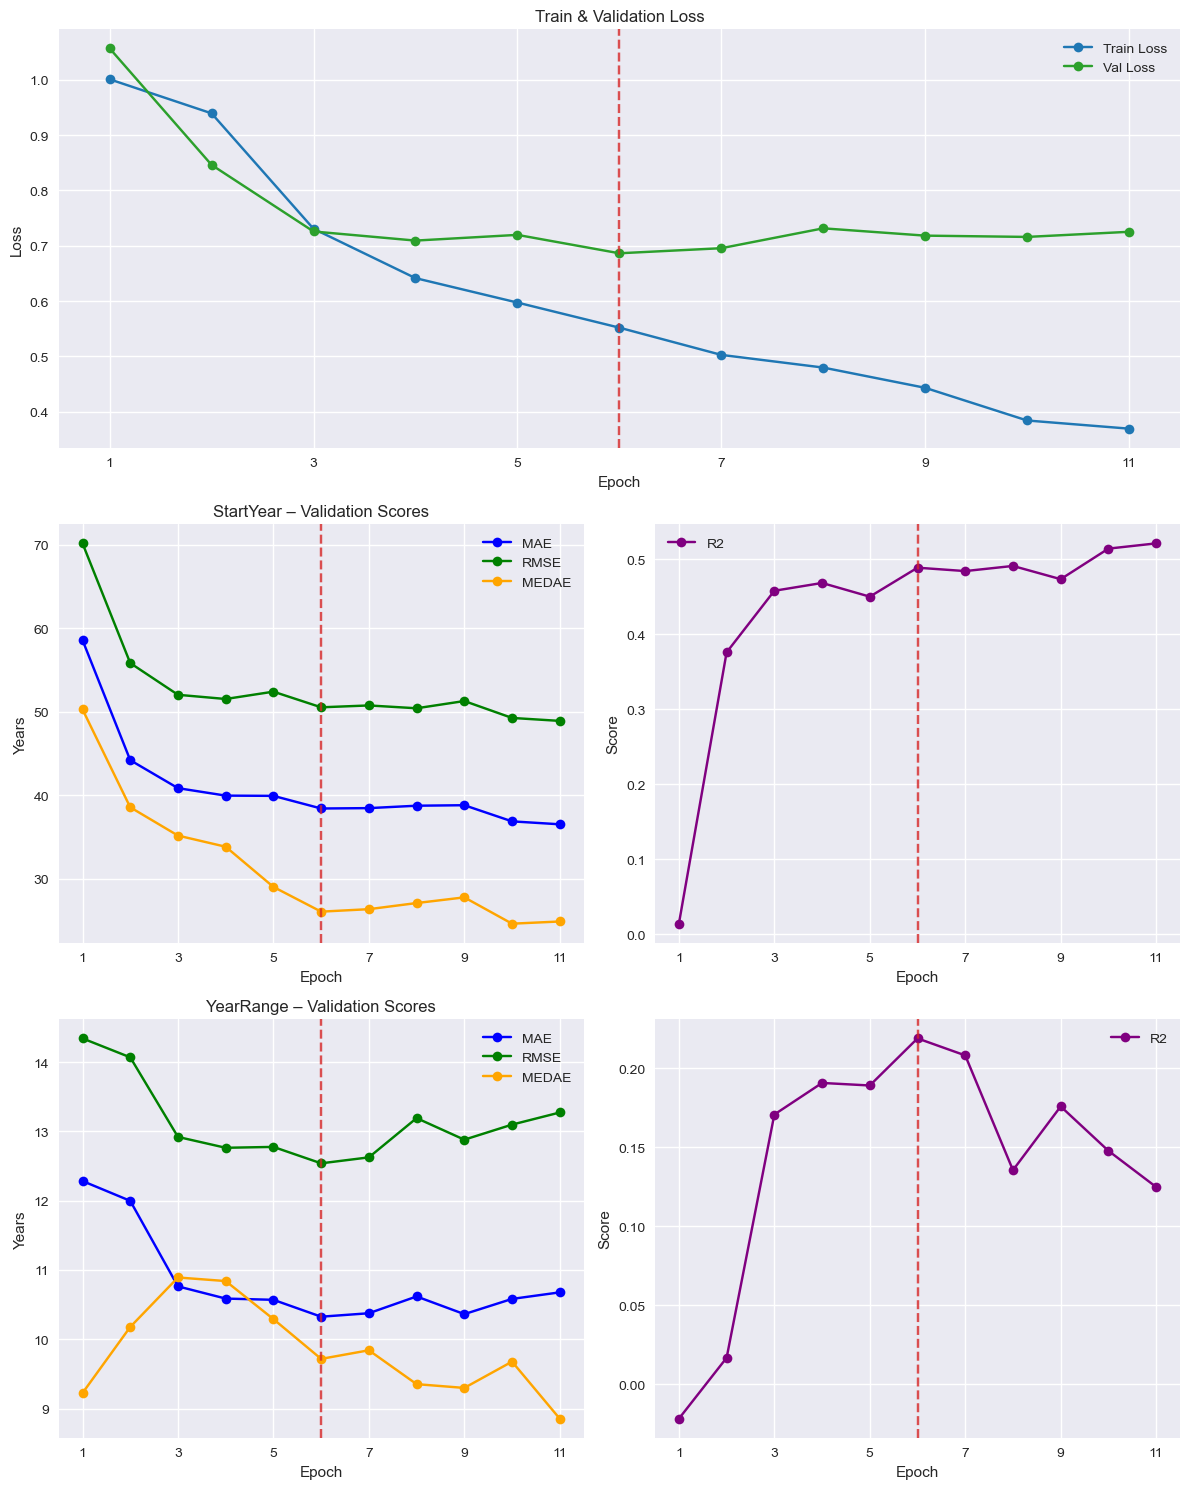



** FEATURE SET: BERT **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 855.75it/s, loss=0.9039]


** Early Stopping
** Restore Model State at Epoch 16
** Final Model:
   train_loss: 0.7577, val_loss: 0.8642, mae: [49.07, 11.16], rmse: [61.07, 13.58], r2: [0.25, 0.08], medae: [43.84, 11.00], 


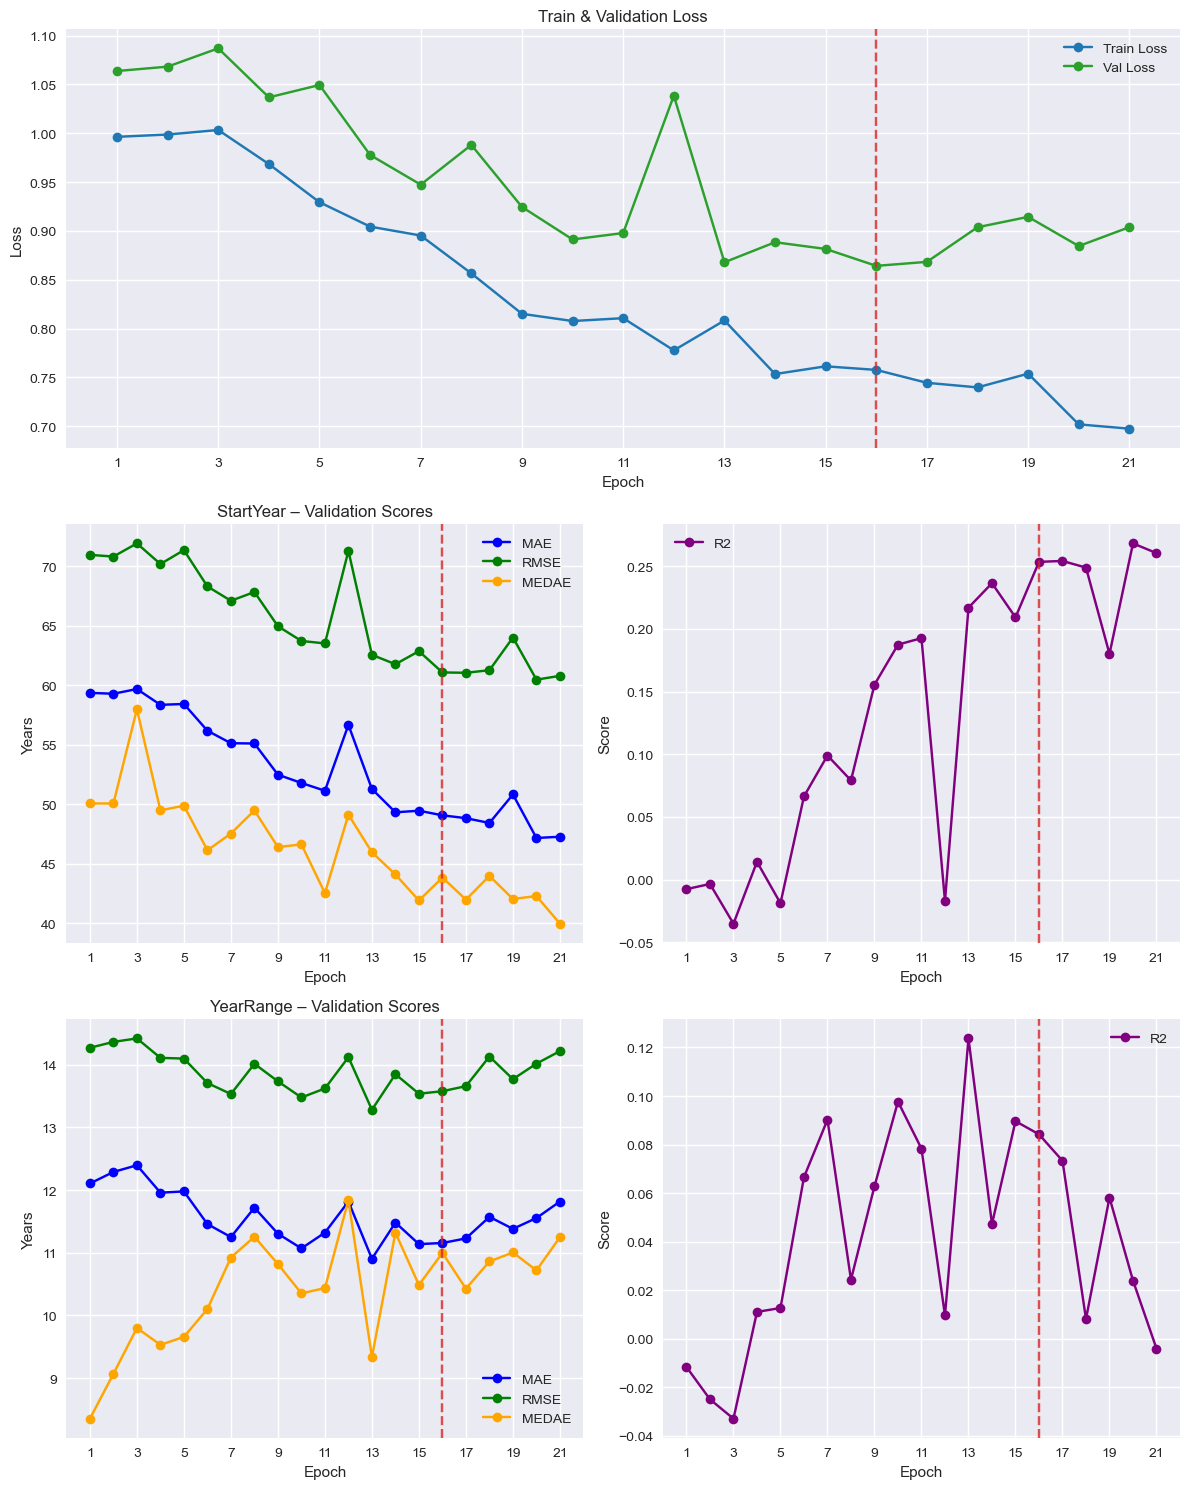



** FEATURE SET: CANNYHOG **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 856.85it/s, loss=1.0728]


** Early Stopping
** Restore Model State at Epoch 1
** Final Model:
   train_loss: 1.0630, val_loss: 1.0683, mae: [59.39, 12.17], rmse: [71.11, 14.30], r2: [-0.01, -0.02], medae: [52.72, 8.63], 


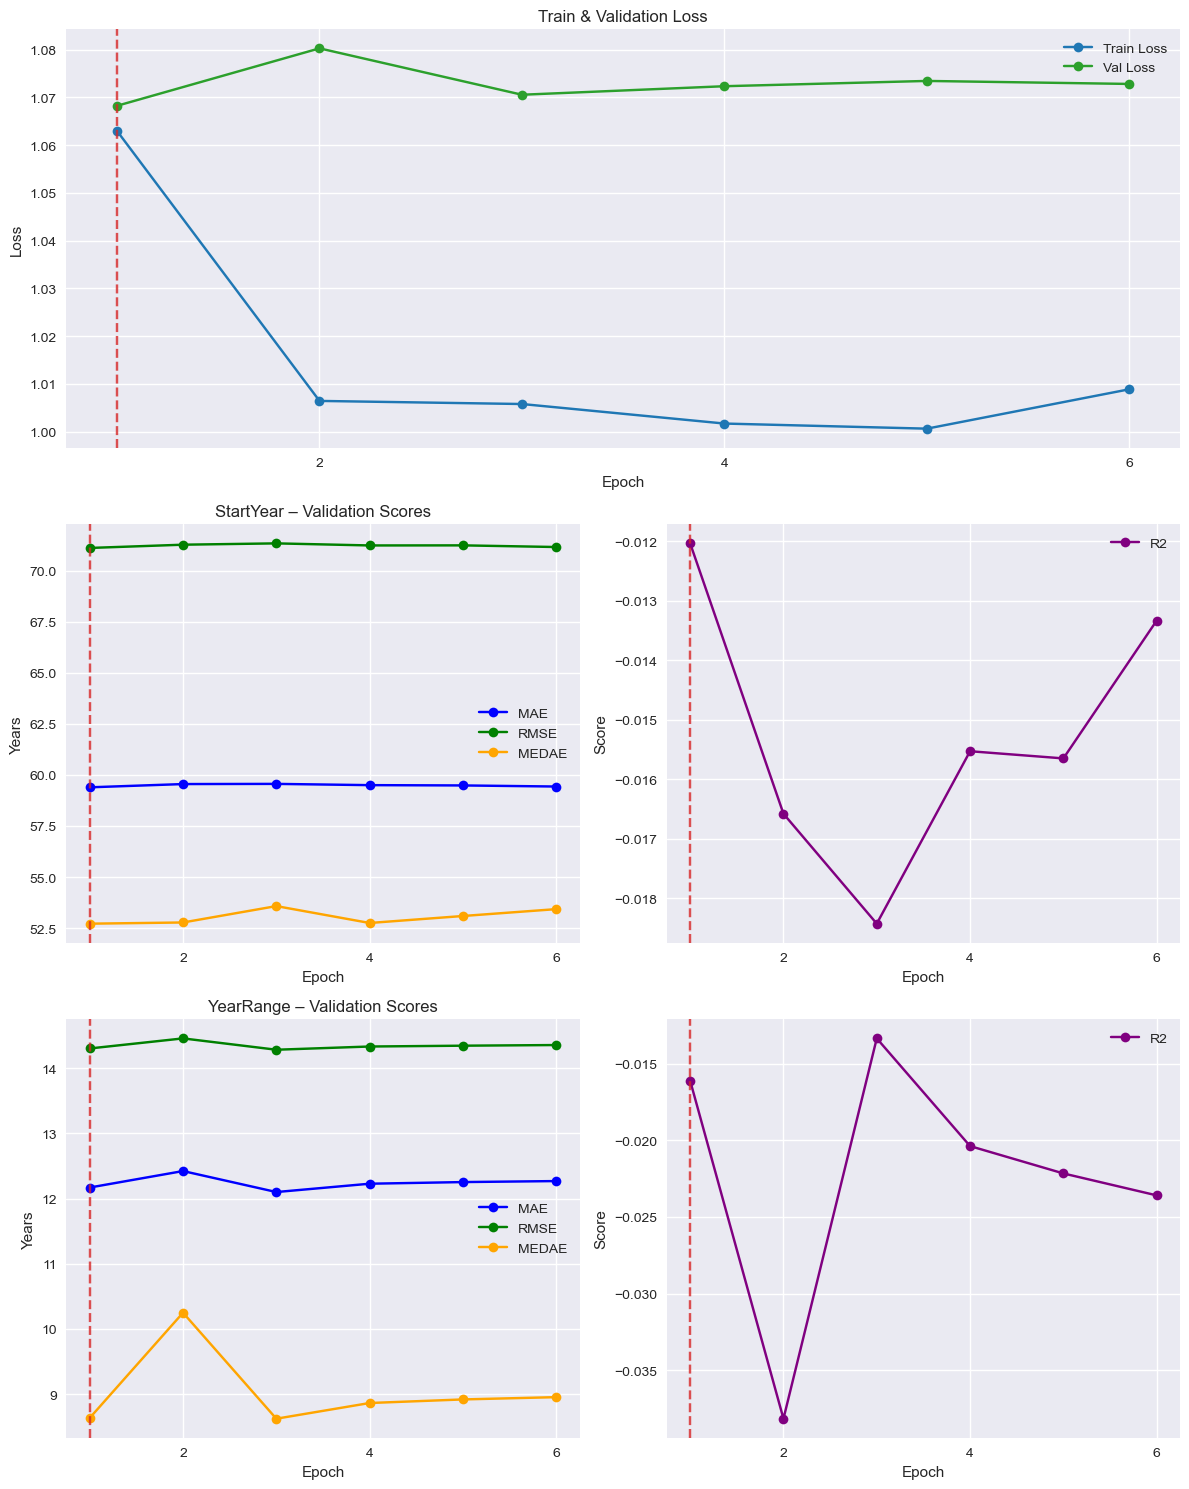



** FEATURE SET: RESNET **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1200.09it/s, loss=0.9626]


** Early Stopping
** Restore Model State at Epoch 6
** Final Model:
   train_loss: 0.8534, val_loss: 0.9620, mae: [52.34, 11.90], rmse: [64.54, 14.29], r2: [0.17, -0.01], medae: [46.61, 8.54], 


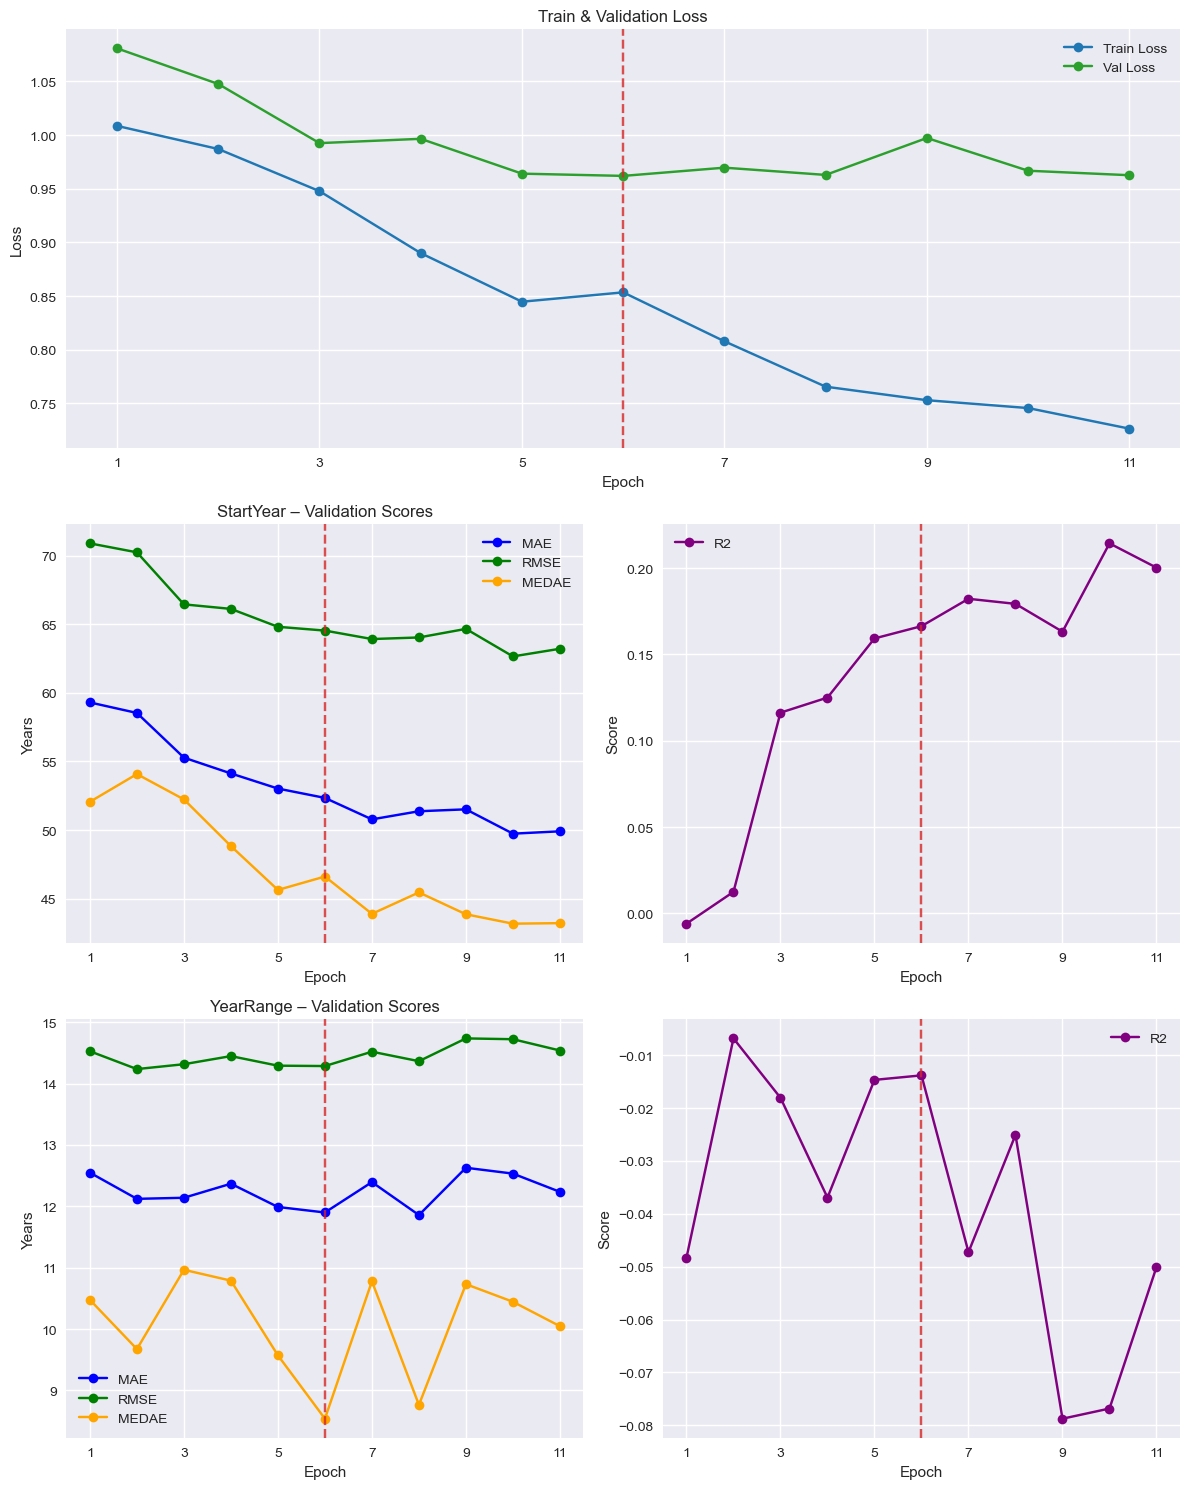



** FEATURE SET: VIT **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1199.51it/s, loss=0.9343]


** Early Stopping
** Restore Model State at Epoch 16
** Final Model:
   train_loss: 0.7567, val_loss: 0.9110, mae: [47.34, 11.84], rmse: [60.46, 14.28], r2: [0.27, -0.01], medae: [37.46, 8.86], 


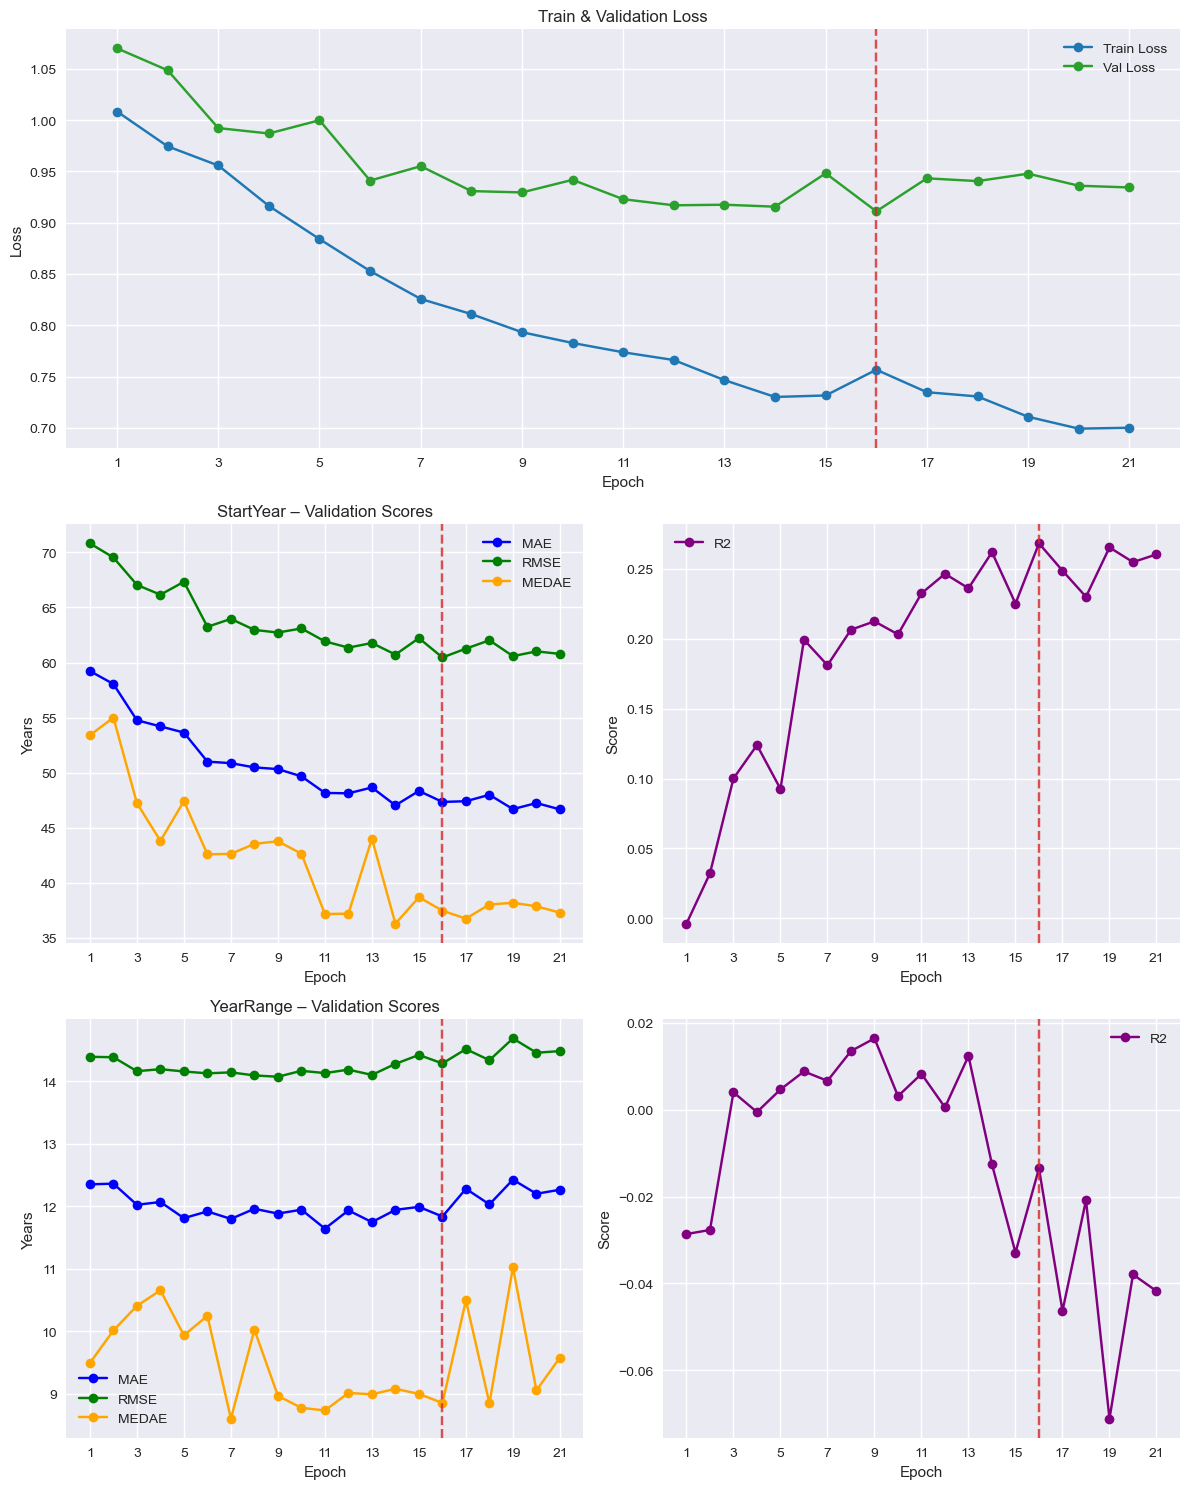



** FEATURE SET: TFIDF + CANNYHOG **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 750.05it/s, loss=0.7460]


** Early Stopping
** Restore Model State at Epoch 8
** Final Model:
   train_loss: 0.6656, val_loss: 0.7285, mae: [40.69, 10.86], rmse: [52.63, 12.86], r2: [0.45, 0.18], medae: [33.99, 11.43], 


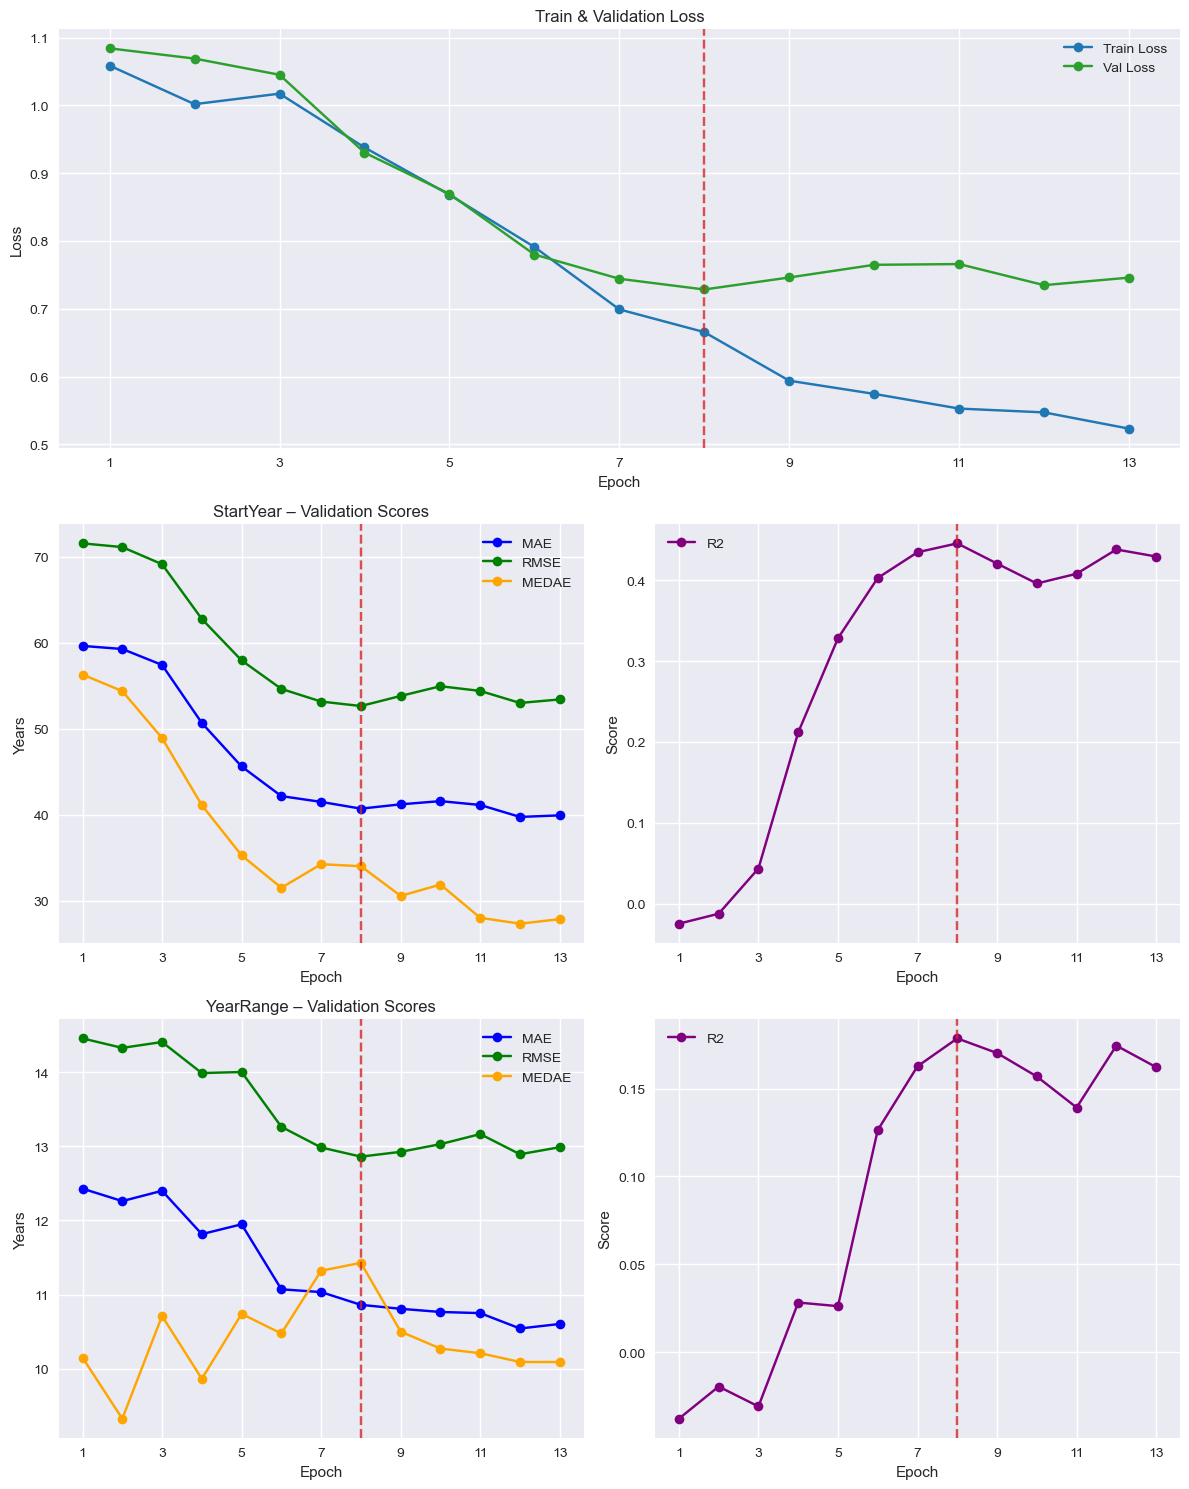



** FEATURE SET: TFIDF + RESNET **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 750.05it/s, loss=0.7007]


** Early Stopping
** Restore Model State at Epoch 7
** Final Model:
   train_loss: 0.4888, val_loss: 0.6467, mae: [34.72, 10.43], rmse: [45.13, 12.87], r2: [0.59, 0.18], medae: [29.05, 9.44], 


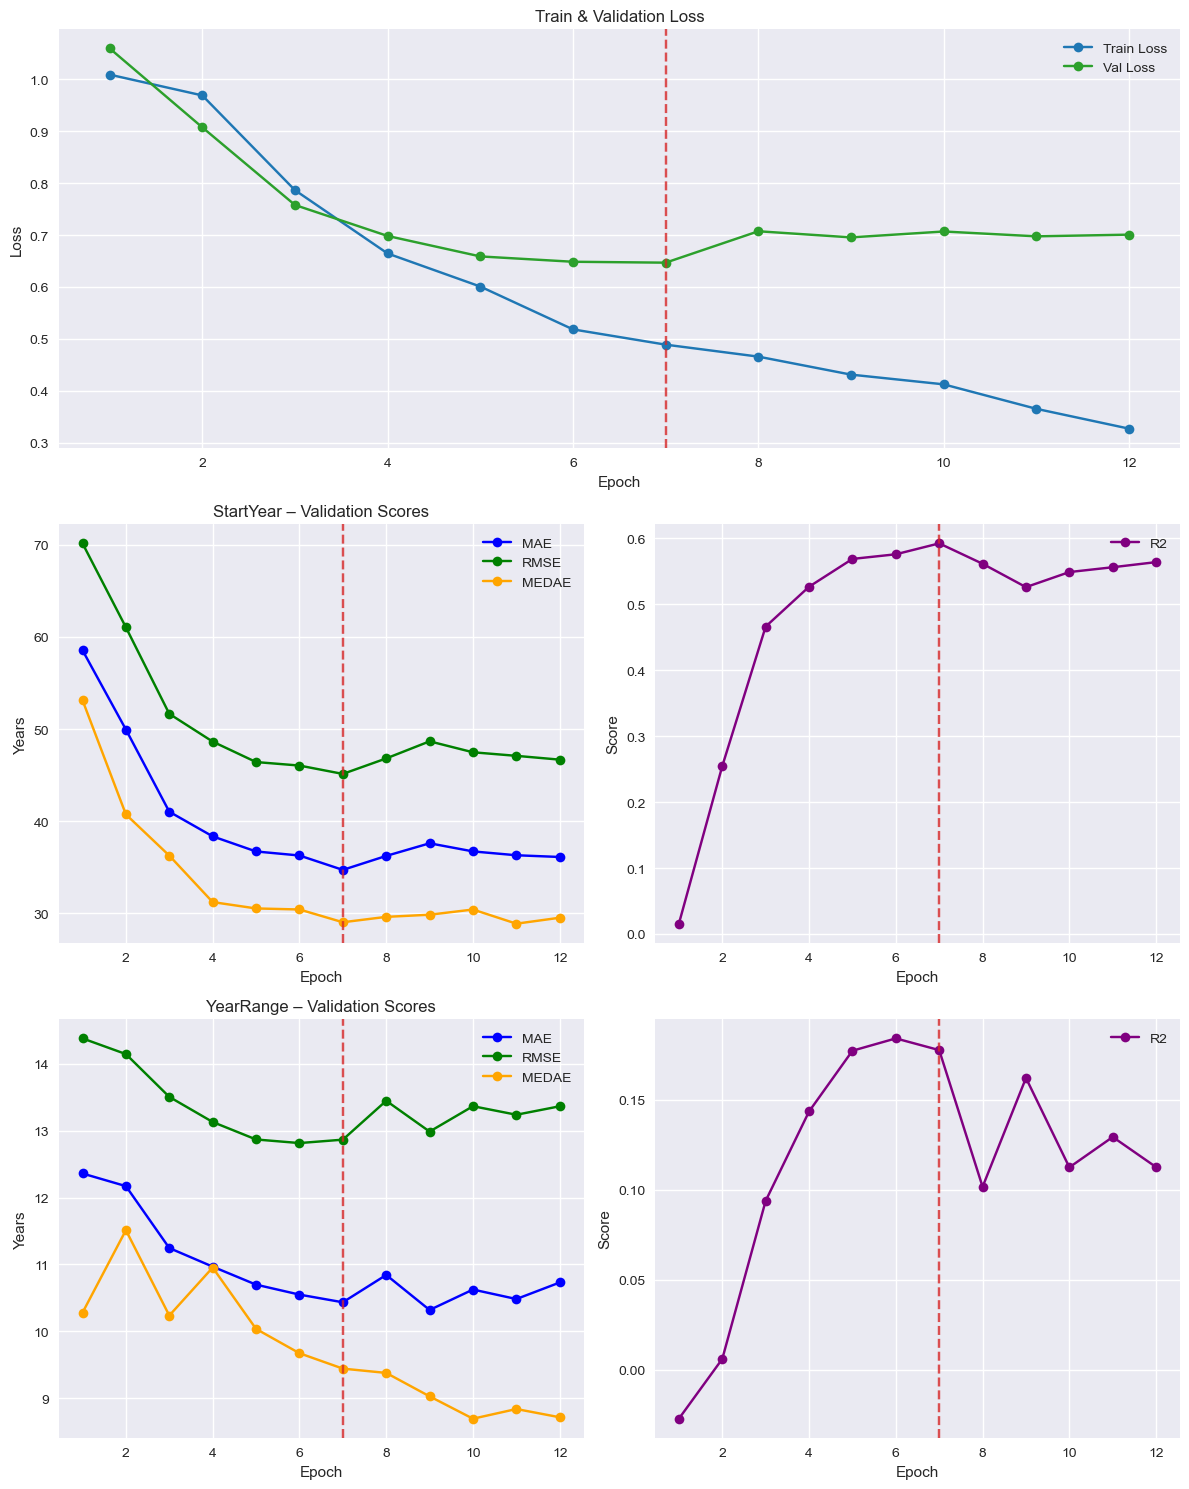



** FEATURE SET: TFIDF + VIT **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 600.01it/s, loss=0.6932]


** Early Stopping
** Restore Model State at Epoch 8
** Final Model:
   train_loss: 0.4605, val_loss: 0.6851, mae: [36.83, 10.40], rmse: [48.17, 12.86], r2: [0.54, 0.18], medae: [27.23, 8.81], 


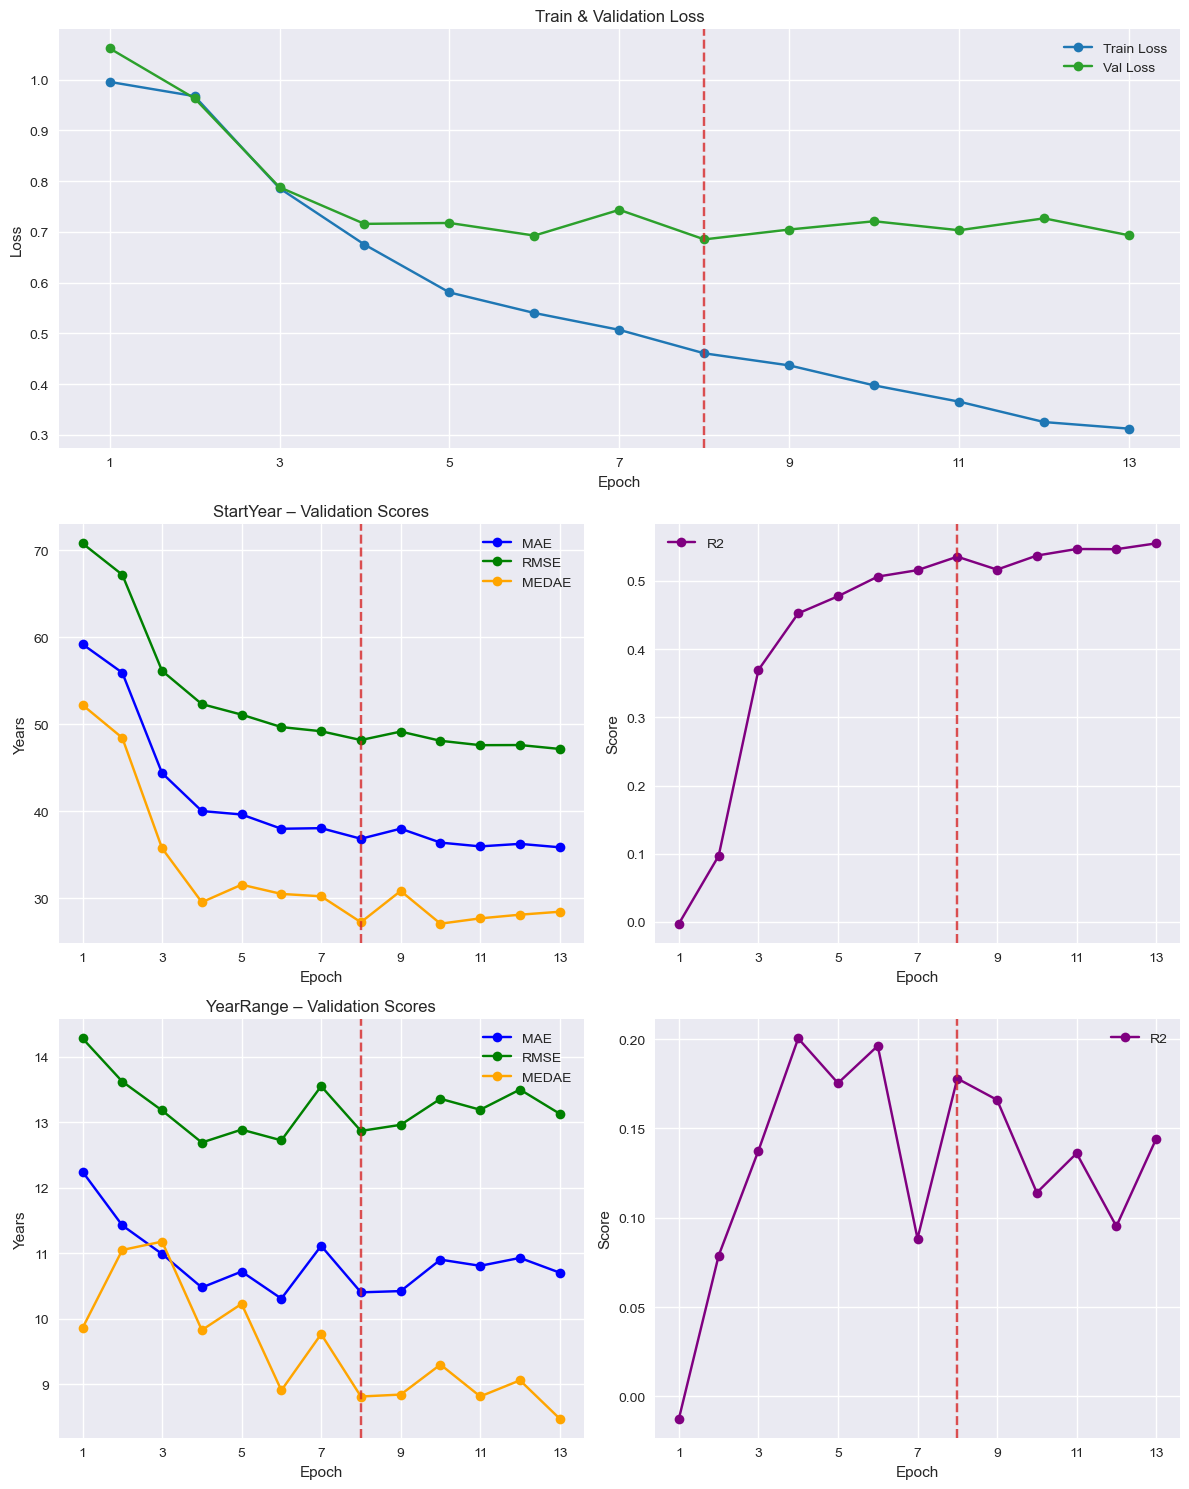



** FEATURE SET: BERT + CANNYHOG **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 857.20it/s, loss=1.0718]


** Early Stopping
** Restore Model State at Epoch 2
** Final Model:
   train_loss: 1.0141, val_loss: 1.0712, mae: [59.54, 12.05], rmse: [71.44, 14.27], r2: [-0.02, -0.01], medae: [55.53, 8.61], 


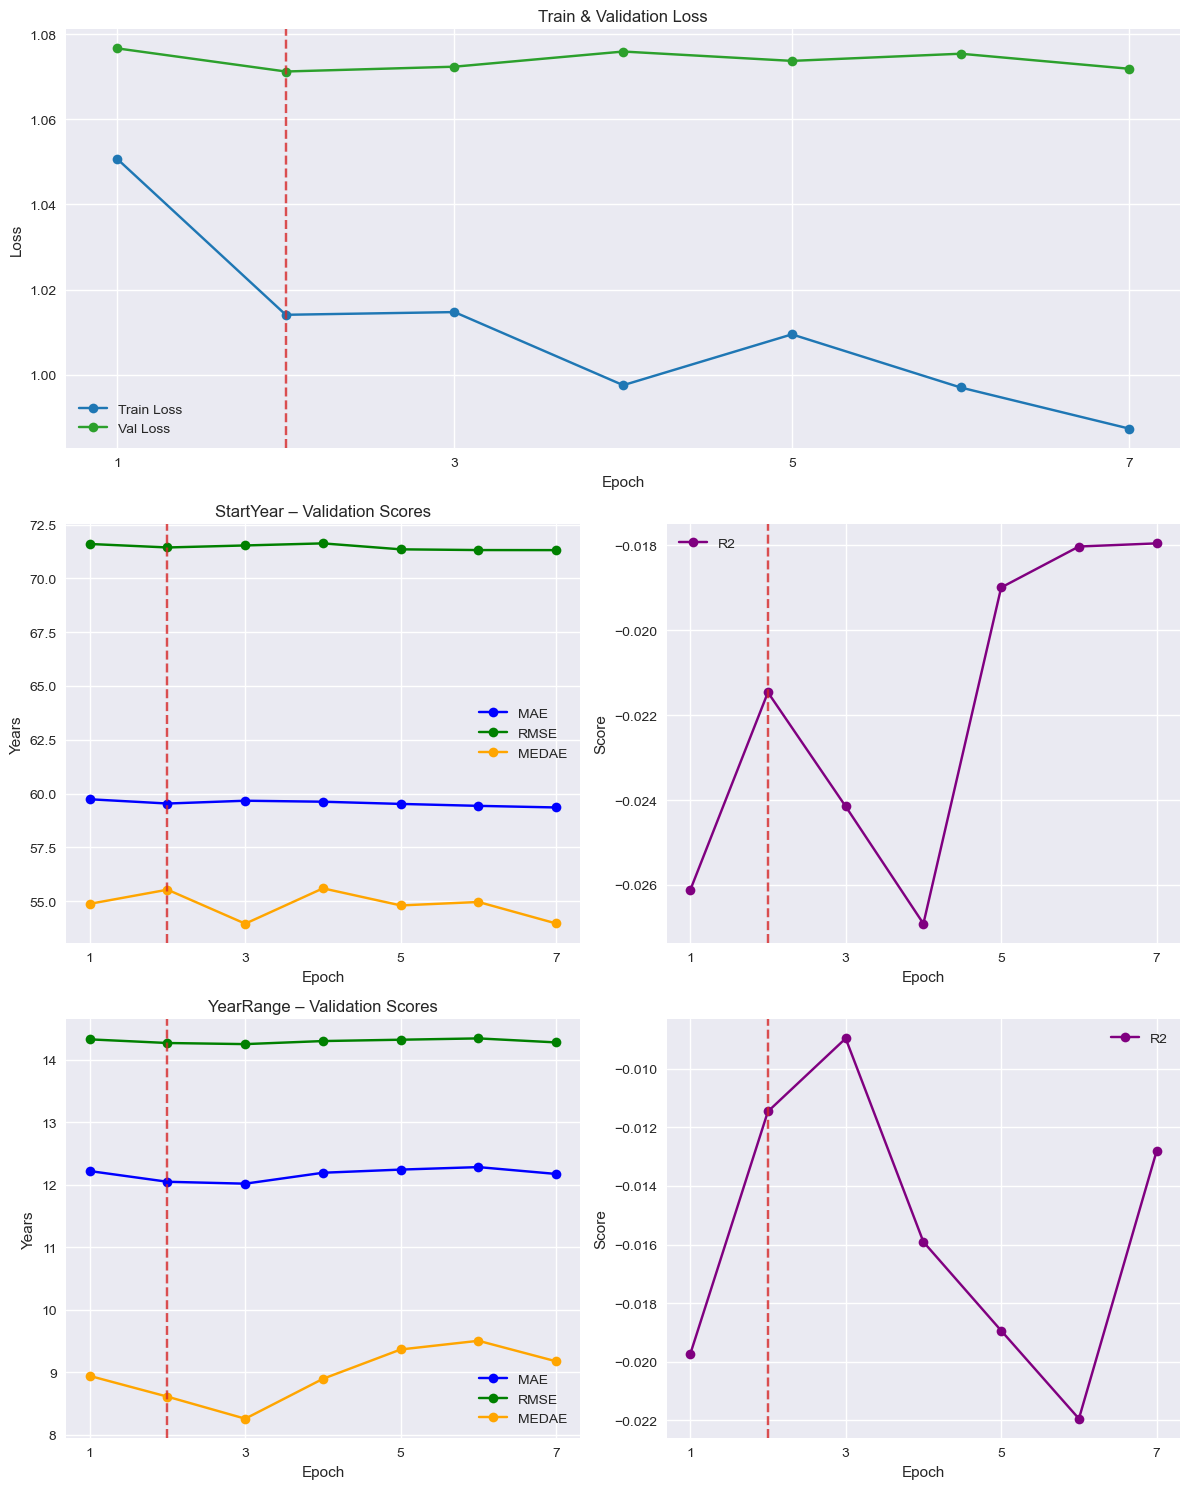



** FEATURE SET: BERT + RESNET **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 856.39it/s, loss=0.8655]


** Early Stopping
** Restore Model State at Epoch 8
** Final Model:
   train_loss: 0.6948, val_loss: 0.8380, mae: [48.11, 10.64], rmse: [60.45, 13.36], r2: [0.27, 0.11], medae: [36.36, 8.87], 


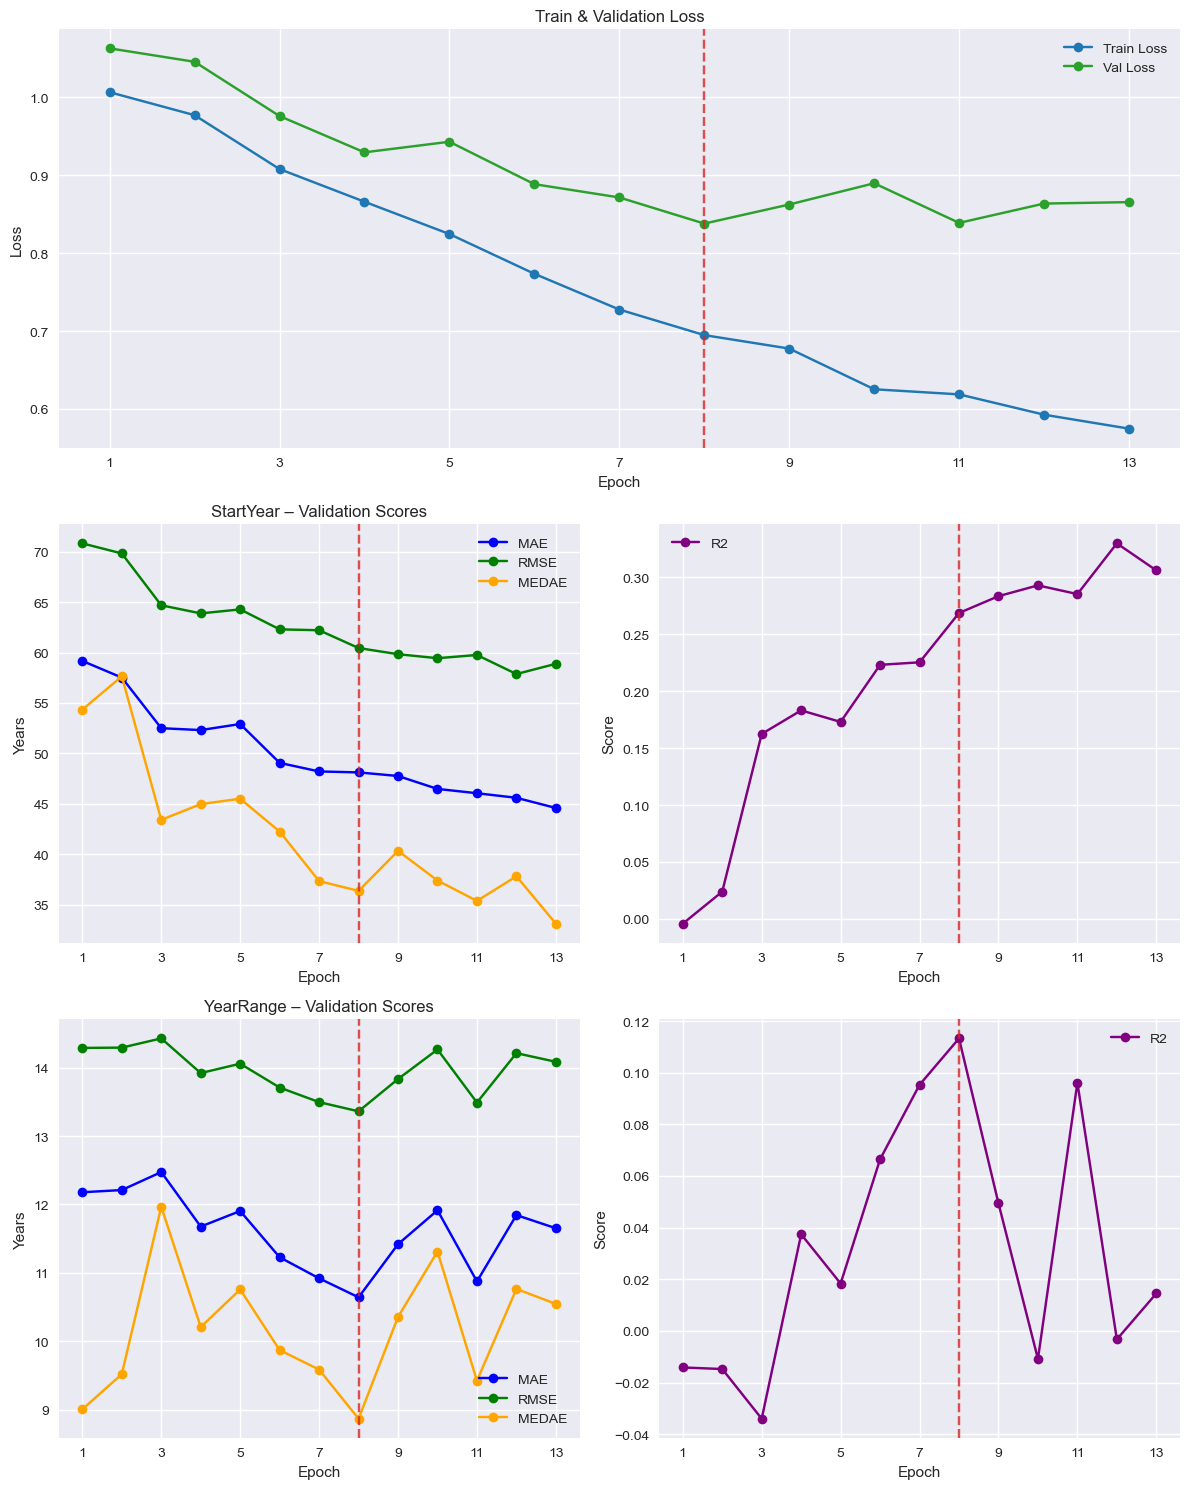



** FEATURE SET: BERT + VIT **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 666.26it/s, loss=0.7912]


** Early Stopping
** Restore Model State at Epoch 27
** Final Model:
   train_loss: 0.5062, val_loss: 0.7647, mae: [40.70, 10.79], rmse: [53.86, 13.32], r2: [0.42, 0.12], medae: [31.44, 9.41], 


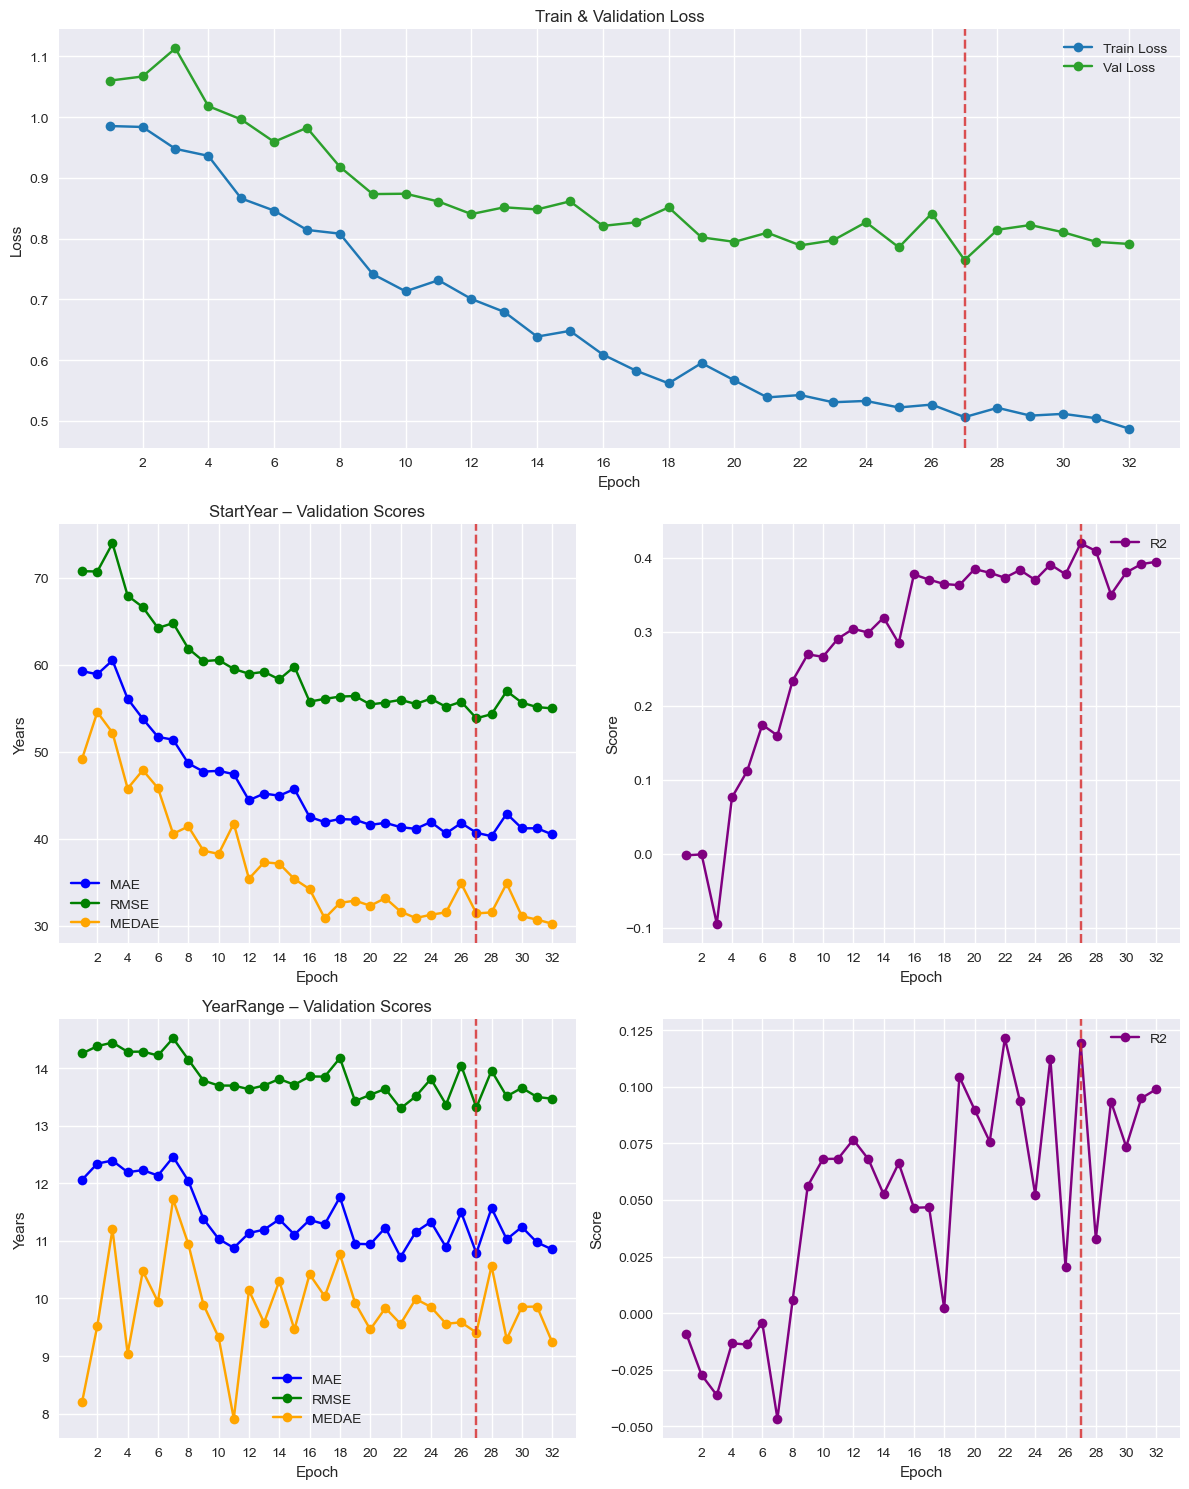

In [20]:
criterion = nn.MSELoss()
metrics = metrics_r

for ft, model in models.items():
    print(f"\n\n** FEATURE SET: {ft.upper()} **")
    models[ft], history = train(model, loaders["train"][ft], loaders["val"][ft], criterion, metrics, y_scaler)
    plot_history(history, targets)